# What happens if we add an attention layer to the dense model?

and can positional embeddings to do better than the simple `temporal_weight_range`.

**TLDR;** It doesn't make our results any better but ... it is pretty cool how easily we can do this

In [1]:
import numpy as np
import tensorflow as tf
from datetime import datetime
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks
from matplotlib import pyplot as plt
from pathlib import Path
from functools import partial
try:
    from utils.plot_history import *
except ModuleNotFoundError:
    if not Path('plot_history.py').is_file():
        !wget https://raw.githubusercontent.com/pete88b/deep_learning_with_python/main/utils/plot_history.py
    from plot_history import *

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-kadjd35k because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
Path('data/models').mkdir(exist_ok=True, parents=True)
if not Path('data/jena_climate_2009_2016.csv').is_file():
    !wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
    !unzip jena_climate_2009_2016.csv.zip -d data
with open("data/jena_climate_2009_2016.csv") as f:
    data = f.read()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(len(header), 'features', len(lines), 'rows of data')
print(header)

15 features 420451 rows of data
['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


# Add date features

## TODO: Make day of week categorical

Categorical day of week might make sense as things like polution from traffic can be different on the weekend.

Also use embedding like fastai tabular?

In [3]:
def create_date_features(date_str):
    d = datetime.strptime(date_str, '%d.%m.%Y %H:%M:%S')
    hour_of_day = d.hour # 0-23
    day_of_week = d.weekday() # Monday is 0 
    day_of_year = int(d.strftime('%j')) # 1-365
    sin_hour_of_day, cos_hour_of_day = [f(2 * np.pi * hour_of_day / 24) for f in [np.sin, np.cos]]
    sin_day_of_year, cos_day_of_year = [f(2 * np.pi * day_of_year / 365) for f in [np.sin, np.cos]]
    return [sin_hour_of_day, cos_hour_of_day, day_of_week, sin_day_of_year, cos_day_of_year]

In [4]:
for line in lines[0:30:6]:
    split_line = line.split(",")
    print(split_line[0], create_date_features(split_line[0]))

01.01.2009 00:10:00 [0.0, 1.0, 3, 0.017213356155834685, 0.9998518392091162]
01.01.2009 01:10:00 [0.25881904510252074, 0.9659258262890683, 3, 0.017213356155834685, 0.9998518392091162]
01.01.2009 02:10:00 [0.49999999999999994, 0.8660254037844387, 3, 0.017213356155834685, 0.9998518392091162]
01.01.2009 03:10:00 [0.7071067811865475, 0.7071067811865476, 3, 0.017213356155834685, 0.9998518392091162]
01.01.2009 04:10:00 [0.8660254037844386, 0.5000000000000001, 3, 0.017213356155834685, 0.9998518392091162]


# Convert data to np and normalize

In [5]:
n_train_samples = 210225
n_val_samples = 105112
n_test_samples = 105114

In [6]:
def data_to_np(use_date_features=False):
    n_date_features = 5 if use_date_features else 0
    temperature = np.zeros((len(lines),))
    raw_data = np.zeros((len(lines), len(header) - 1 + n_date_features))
    for i, line in enumerate(lines):
        split_line = line.split(",")
        values = [float(x) for x in split_line[1:]] 
        if use_date_features:
            values = values + create_date_features(split_line[0])
        temperature[i] = values[1]
        raw_data[i, :] = values[:] # features inc. temp
    mean = raw_data[:n_train_samples].mean(axis=0)
    std = raw_data[:n_train_samples].std(axis=0)
    raw_data -= mean
    raw_data /= std
    return temperature, raw_data, mean, std

# Create datasets

In [7]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256 # 512 is too big for dense model with attention
def new_dataset(start_index, end_index):
    dataset = keras.utils.timeseries_dataset_from_array(
            raw_data[:-delay],
            targets=temperature[delay:],
            sampling_rate=sampling_rate,
            sequence_length=sequence_length,
            shuffle=start_index == 0, # only shuffle train
            batch_size=batch_size,
            start_index=start_index,
            end_index=end_index)
    return dataset.prefetch(tf.data.AUTOTUNE)

In [8]:
def new_datasets():
    train_dataset = new_dataset(0, n_train_samples)
    val_dataset = new_dataset(n_train_samples, n_train_samples + n_val_samples)
    test_dataset = new_dataset(n_train_samples + n_val_samples, None)
    return train_dataset, val_dataset, test_dataset

# Functions to build and train models

`positional_embeddings ... output_dim=raw_data.shape[-1]` might make sense but for this problem, less is better

It seems to be more common to sum when we "apply embedded positions" and "attention res" but I get better results by multiplying 
- I'm thinking that this allows both embedded positions and the attention layer to have a greater effect
    - i.e. they could potentially zero out features going into the dense layers

In [9]:
def new_model(l2_factor=None, dropout_rate=None, fit_residual=False, use_attention=True):
    inputs = layers.Input(shape=(sequence_length, raw_data.shape[-1]))
    position_embeddings = layers.Embedding(input_dim=120, output_dim=1)
    embedded_positions = position_embeddings(tf.range(start=0, limit=120, delta=1))
    inputs2 = inputs * embedded_positions # apply embedded positions
    if use_attention:
        x = layers.MultiHeadAttention(num_heads=2, key_dim=128)(inputs2, inputs2, inputs2)
        x = layers.LayerNormalization()(inputs2 * x) # attention res
        x = layers.Flatten()(x)
    else:
        x = layers.Flatten()(inputs2)
    kernel_regularizer = None if l2_factor is None else regularizers.l2(l2_factor) 
    x = layers.Dense(16, activation='relu', kernel_regularizer=kernel_regularizer)(x)
    if dropout_rate is not None:
        x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(1)(x)
    if fit_residual:
        x = tf.expand_dims(inputs[:, -1, 1] * std[1] + mean[1], -1) + x
    return keras.Model(inputs, x)

In [10]:
def compile_and_fit(model, model_tag):
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    kwargs = dict(monitor='val_mae', verbose=1)
    cbs = [callbacks.ModelCheckpoint(f'data/models/jena_{model_tag}.keras', 
                                     save_best_only=True, **kwargs),
           callbacks.EarlyStopping(patience=2, **kwargs)]
    history = model.fit(train_dataset,
                        epochs=50,
                        validation_data=val_dataset,
                        callbacks=cbs)
    del history.history['loss'] # we'll just plot mae
    plot_history(history, ignore_first_n=0)

In [11]:
def evaluate_model(model_tag):
    model = keras.models.load_model(f'data/models/jena_{model_tag}.keras')
    print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f} for model tag: {model_tag}")

# The common-sense, non-machine learning baseline

```
Naive validation MAE 2.4417357485655167
Naive test MAE 2.621898451761206

```

In [12]:
temperature, raw_data, mean, std = data_to_np(use_date_features=True)
train_dataset, val_dataset, test_dataset = new_datasets()
for xb,yb in test_dataset:
    print(xb.shape, yb.shape, tf.reduce_mean(xb))
    break

(256, 120, 19) (256,) tf.Tensor(-0.0422547269572423, shape=(), dtype=float64)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 19)]    0           []                               
                                                                                                  
 tf.math.multiply (TFOpLambda)  (None, 120, 19)      0           ['input_1[0][0]']                
                                                                                                  
 multi_head_attention (MultiHea  (None, 120, 19)     20243       ['tf.math.multiply[0][0]',       
 dAttention)                                                      'tf.math.multiply[0][0]',       
                                                                  'tf.math.multiply[0][0]']       
                                                                                              

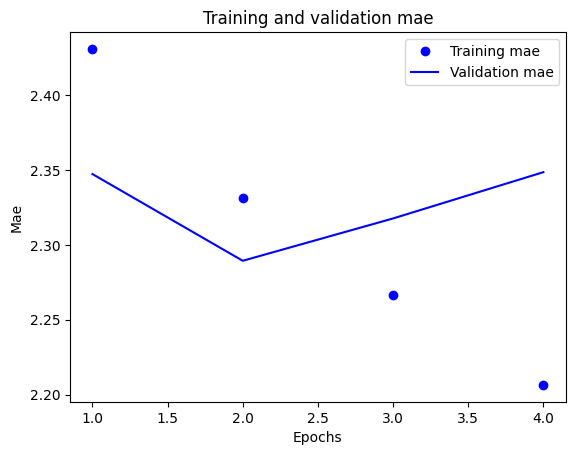

In [13]:
model = new_model(l2_factor=1e-2, dropout_rate=0.5, fit_residual=True)
model.summary()
compile_and_fit(model, 'dense_0')

In [14]:
evaluate_model('dense_0')

405/405 [==============================] - 4s 10ms/step - loss: 9.7928 - mae: 2.4117
Test MAE: 2.41 for model tag: dense_0
